In [2]:
import bisect
import math
import os
from collections import OrderedDict

import numpy as np
import pylab as plt
import pymzml
from scipy.stats import pearsonr

In [ ]:
#from pyteomics import mzml, auxiliary
#with mzml.read('/Users/tong/Downloads/Beer_multibeers_2_fullscan1.mzML') as reader:
   # auxiliary.print_tree(next(reader))
    #for spectrum in reader:
        #print(spectrum)
        #mz=list(spectrum['m/z array'])
        #intensity=list(spectrum['intensity array'])
        #scan_n.append(spectrum['count'])
        #rt=spectrum['scanList']['scan'][0]['scan start time']
        #print(len(mz))
        #print(len(intensity))
        #print(scan_n)
        #print(rt)

In [3]:
# Object to store a RoI
# Maintains 3 lists -- mz, rt and intensity
# When a new point (mz,rt,intensity) is added, it updates the 
# list and the mean mz which is required.
class Roi(object):
    def __init__(self, mz, rt, intensity, scan_n):
        if type(mz) == list:
            self.mz_list = mz
        else:
            self.mz_list = [mz]
        if type(rt) == list:
            self.rt_list = rt
        else:
            self.rt_list = [rt]
        if type(intensity) == list:
            self.intensity_list = intensity
        else:
            self.intensity_list = [intensity]
        
        if type(scan_n) == list:
            self.scan_n_list = scan_n
        else:
            self.scan_n_list = [scan_n]

        self.n = len(self.mz_list)
        self.mz_sum = sum(self.mz_list)
        self.length_in_seconds = self.rt_list[-1] - self.rt_list[0]

        self.current_gap_run = 0

    def get_mean_mz(self):
        return self.mz_sum / self.n

    def get_apex_rt(self):
        rt = self.rt_list[0]
        max_i = self.intensity_list[0]
        for i,intensity in enumerate(self.intensity_list):
            if intensity > max_i:
                max_i = intensity
                rt = self.rt_list[i]
        return rt
    
    def get_apex_scan_no(self):
        scan_no = self.scan_n_list[0]
        max_i = self.intensity_list[0]
        for i,intensity in enumerate(self.intensity_list):
            if intensity > max_i:
                max_i = intensity
                scan_n = self.scan_n_list[i]
        return scan_n
        
    def get_max_intensity(self):
        return max(self.intensity_list)

    def get_min_intensity(self):
        return min(self.intensity_list)

    def get_autocorrelation(self, lag=1):
        return pd.Series(self.intensity_list).autocorr(lag=lag)

    def add(self, mz, rt, intensity, scan_no):
        self.mz_list.append(mz)
        self.rt_list.append(rt)
        self.intensity_list.append(intensity)
        self.scan_n_list.append(scan_no)
        self.mz_sum += mz
        self.n += 1
        self.length_in_seconds = self.rt_list[-1] - self.rt_list[0]
    
    def get_intensity_list(self):
        return self.intensity_list
    
    def get_mz_list(self):
        return self.mz_list
    
    def get_rt_list(self):
        return self.rt_list

    def __lt__(self, other):
        return self.get_mean_mz() <= other.get_mean_mz()

    def __repr__(self):
        return 'ROI with data points=%d mz (%.4f-%.4f) rt (%.4f-%.4f) mean_mz (%.4f) \n' % (
            self.n,
            self.mz_list[0], self.mz_list[-1],
            self.rt_list[0], self.rt_list[-1],
            self.get_mean_mz())



# Find the RoI that a particular mz falls into
# If it falls into nothing, return None
# mz_tol is the window above and below the 
# mean_mz of the RoI. E.g. if mz_tol = 1 Da, then it looks
# plus and minus 1Da
def match(mz, roi_list, mz_tol, mz_units='Da'):
    if len(roi_list) == 0:
        return None
    pos = bisect.bisect_right(roi_list, mz)

    if pos == len(roi_list):
        if mz_units == 'Da':
            dist_left = mz.get_mean_mz() - roi_list[pos - 1].get_mean_mz()
        else:  # ppm
            dist_left = 1e6 * (mz.get_mean_mz() - roi_list[pos - 1].get_mean_mz()) / mz.get_mean_mz()

        if dist_left < mz_tol:
            return roi_list[pos - 1]
        else:
            return None
    elif pos == 0:
        if mz_units == 'Da':
            dist_right = roi_list[pos].get_mean_mz() - mz.get_mean_mz()
        else:  # ppm
            dist_right = 1e6 * (roi_list[pos].get_mean_mz() - mz.get_mean_mz()) / mz.get_mean_mz()

        if dist_right < mz_tol:
            return roi_list[pos]
        else:
            return None
    else:
        if mz_units == 'Da':
            dist_left = mz.get_mean_mz() - roi_list[pos - 1].get_mean_mz()
            dist_right = roi_list[pos].get_mean_mz() - mz.get_mean_mz()
        else:  # ppm
            dist_left = 1e6 * (mz.get_mean_mz() - roi_list[pos - 1].get_mean_mz()) / mz.get_mean_mz()
            dist_right = 1e6 * (roi_list[pos].get_mean_mz() - mz.get_mean_mz()) / mz.get_mean_mz()

        if dist_left < mz_tol and dist_right > mz_tol:
            return roi_list[pos - 1]
        elif dist_left > mz_tol and dist_right < mz_tol:
            return roi_list[pos]
        elif dist_left < mz_tol and dist_right < mz_tol:
            if dist_left <= dist_right:
                return roi_list[pos - 1]
            else:
                return roi_list[pos]
        else:
            return None


def roi_correlation(roi1, roi2, min_rt_point_overlap=5, method='pearson'):
    # flip around so that roi1 starts earlier (or equal)
    if roi2.rt_list[0] < roi1.rt_list[0]:
        temp = roi2
        roi2 = roi1
        roi1 = temp

    # check that they meet the min_rt_point overlap
    if roi1.rt_list[-1] < roi2.rt_list[0]:
        # no overlap at all
        return 0.0


    # use the scan numbers to make two nice lists
    # roi1 is the earlier of the two
    min_scan_number = min(roi1.scan_n_list[0],roi2.scan_n_list[0])
    max_scan_number = max(roi1.scan_n_list[-1],roi2.scan_n_list[-1])

    r1 = []
    r2 = []
    for scan_no in range(min_scan_number,max_scan_number+1):
        if scan_no in roi1.scan_n_list:
            r1.append(roi1.intensity_list[roi1.scan_n_list.index(scan_no)])
        else:
            r1.append(0.0)
        if scan_no in roi2.scan_n_list:
            r2.append(roi2.intensity_list[roi2.scan_n_list.index(scan_no)])
        else:
            r2.append(0.0)
        

    # # find the position of the first element in roi2 in roi1
    # pos = roi1.rt_list.index(roi2.rt_list[0])

    # # print roi1.rt_list
    # # print roi2.rt_list
    # # print pos

    # total_length = max([len(roi1.rt_list), len(roi2.rt_list) + pos])
    # # print total_length

    # r1 = np.zeros((total_length), np.double)
    # r2 = np.zeros_like(r1)

    # r1[:len(roi1.rt_list)] = roi1.intensity_list
    # r2[pos:pos + len(roi2.rt_list)] = roi2.intensity_list

    # print 
    # for i,a in enumerate(r1):
    #     print "{:10.4f}\t{:10.4f}".format(a,r2[i])
    if method == 'pearson':
        r, _ = pearsonr(r1, r2)
    else:
        r = cosine_score(r1, r2)

    return r


def cosine_score(u, v):
    numerator = (u * v).sum()
    denominator = np.sqrt((u * u).sum()) * np.sqrt((v * v).sum())
    return numerator / denominator

# Make the RoI from an input file
# mz_units = Da for Daltons
# mz_units = ppm for ppm
#input_file = '/Users/tong/Downloads/Beer_multibeers_2_fullscan1.mzML'
def make_roi(input_file, mz_tol=0.001, mz_units='Da', min_length=10, min_intensity=50000, start_rt=0, stop_rt=10000000,length_units = "scans",max_gap_run = 0):
    # input_file = 'Beer_multibeers_1_fullscan1.mzML'

    if not mz_units == 'Da' and not mz_units == 'ppm':
        logger.warning("Unknown mz units, use Da or ppm")
        return None, None

    run = pymzml.run.Reader(input_file, MS1_Precision=5e-6,
                            extraAccessions=[('MS:1000016', ['value', 'unitName'])],
                            obo_version='4.0.1')

    live_roi = []
    dead_roi = []
    junk_roi = []

    for scan_no,spectrum in enumerate(run):
        # print spectrum['centroid_peaks']
        if spectrum['ms level'] == 1:
            live_roi.sort()
            # current_ms1_scan_rt, units = spectrum['scan start time'] # this no longer works
            current_ms1_scan_rt, units = spectrum.scan_time
            if units == 'minute':
                current_ms1_scan_rt *= 60.0

            if current_ms1_scan_rt < start_rt:
                continue
            if current_ms1_scan_rt > stop_rt:
                break

            # print current_ms1_scan_rt
            # print spectrum.peaks
            not_grew = set(live_roi)
            for mz, intensity in spectrum.peaks('raw'):
                if intensity >= min_intensity:
                    match_roi = match(Roi(mz, 0, 0, 0), live_roi, mz_tol, mz_units=mz_units)
                    if match_roi:
                        match_roi.add(mz, current_ms1_scan_rt, intensity, scan_no)
                        match_roi.current_gap_run = 0 # reset
                        if match_roi in not_grew:
                            not_grew.remove(match_roi)
                    else:
                        bisect.insort_right(live_roi, Roi(mz, current_ms1_scan_rt, intensity, scan_no))

            for roi in not_grew:
                roi.current_gap_run += 1
                if roi.current_gap_run > max_gap_run:
                    if length_units == "scans":
                        if roi.n >= min_length:
                            dead_roi.append(roi)
                        else:
                            junk_roi.append(roi)
                    else:
                        if roi.length_in_seconds >= min_length:
                            dead_roi.append(roi)
                        else:
                            junk_roi.append(roi)
                    pos = live_roi.index(roi)
                    del live_roi[pos]

            # logger.debug("Scan @ {}, {} live ROIs".format(current_ms1_scan_rt, len(live_roi)))

    # process all the live ones - keeping only those that 
    # are longer than the minimum length
    good_roi = dead_roi
    for roi in live_roi:
        if roi.n >= min_length:
            good_roi.append(roi)
        else:
            junk_roi.append(roi)
    return good_roi

In [4]:
#file1

In [5]:
input_file = '/Users/tong/Downloads/Beer_multibeers_1_fullscan1.mzML'
good_roi=make_roi(input_file)

In [6]:
good_roi[3].get_intensity_list()

[68205.34375,
 59427.58203125,
 51597.18359375,
 63282.08984375,
 53888.0078125,
 53193.890625,
 55338.33203125,
 51303.3828125,
 74622.34375,
 51801.46875]

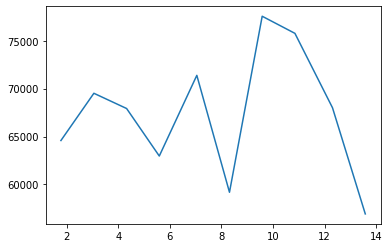

In [7]:
#plot roi intensity
intensity_0=np.array(good_roi[2].get_intensity_list())
rt_0=np.array(good_roi[2].get_rt_list())
rt_0
plt.plot(rt_0,intensity_0)

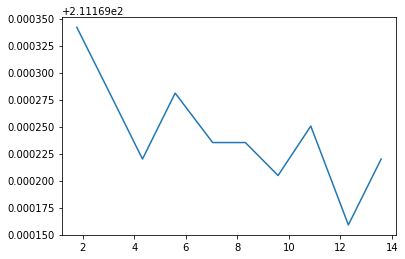

In [8]:
#plot roi mz
mz_0=np.array(good_roi[2].get_mz_list())
rt_0=np.array(good_roi[2].get_rt_list())
rt_0
plt.plot(rt_0,mz_0)

In [9]:
def greedy_roi_cluster(roi_list, corr_thresh=0.9, corr_type='cosine'):
    # sort in descending intensity
    roi_list_copy = [r for r in roi_list]
    roi_list_copy.sort(key=lambda x: max(x.intensity_list), reverse=True)
    roi_clusters = []
    while len(roi_list_copy) > 0:
        roi_clusters.append([roi_list_copy[0]])
        remove_idx = [0]
        if len(roi_list_copy) > 1:
            for i, r in enumerate(roi_list_copy[1:]):
                corr = roi_correlation(roi_list_copy[0], r)
                if corr > corr_thresh:
                    roi_clusters[-1].append(r)
                    remove_idx.append(i + 1)
        remove_idx.sort(reverse=True)
        for r in remove_idx:
            del roi_list_copy[r]

    return roi_clusters

In [10]:
cluster=greedy_roi_cluster(good_roi)

In [11]:
print(cluster)

[[ROI with data points=596 mz (116.0711-116.0706) rt (661.0790-1440.1600) mean_mz (116.0706) 
, ROI with data points=332 mz (117.0740-117.0738) rt (690.9190-1115.5300) mean_mz (117.0739) 
, ROI with data points=338 mz (70.0652-70.0651) rt (678.4980-1110.2400) mean_mz (70.0652) 
, ROI with data points=58 mz (117.0678-117.0676) rt (700.8830-772.2740) mean_mz (117.0676) 
, ROI with data points=62 mz (118.0747-118.0748) rt (699.6410-775.9800) mean_mz (118.0748) 
, ROI with data points=76 mz (157.0970-157.0973) rt (676.0220-769.8030) mean_mz (157.0972) 
, ROI with data points=42 mz (118.0772-118.0769) rt (707.2470-758.6560) mean_mz (118.0771) 
, ROI with data points=38 mz (71.0685-71.0686) rt (707.2470-751.1910) mean_mz (71.0685) 
, ROI with data points=18 mz (231.1344-231.1340) rt (710.9680-732.0400) mean_mz (231.1339) 
], [ROI with data points=870 mz (118.0863-118.0861) rt (0.1164-1115.5300) mean_mz (118.0862) 
, ROI with data points=81 mz (119.0897-119.0898) rt (616.3950-715.9560) mean_m

In [164]:
shift_file = '/Users/tong/Downloads/shift.txt'
shifts = []
adduct_file = open(shift_file, mode='r')
for line in adduct_file:
    shifts.append(float(line))
adduct_file.close()

In [165]:
all_shifts=[]
for i in range(len(shifts)):
    for j in range(i+1,len(shifts)):
        all_shifts.append(abs(shifts[i]-shifts[j]))

In [167]:
shift_list = list(set(all_shifts))
shift_list = [r for r in shift_list if r>18 and r<19]
print(shift_list)

[18.977940823999973, 18.010559999999973, 18.977940824]


In [168]:
def greedy_isotope_cluster(roi_list, corr_thresh=0.9,shift_low=0.95,shift_high=1.05, corr_type='cosine'):
    # sort in descending intensity
    roi_list_copy = [r for r in roi_list]
    roi_list_copy.sort(key=lambda x: max(x.intensity_list), reverse=True)
    roi_clusters = []
    #find isotope
    while len(roi_list_copy) > 0:
        roi_clusters.append([roi_list_copy[0]])
        remove_idx = [0]
        if len(roi_list_copy) > 1:
            for i, r in enumerate(roi_list_copy[1:]):
                corr = roi_correlation(roi_list_copy[0], r)
                shift=r.get_mean_mz()-roi_list_copy[0].get_mean_mz()
                if corr > corr_thresh and shift>shift_low and shift<shift_high:
                    roi_clusters[-1].append(r)
                    remove_idx.append(i + 1)
        remove_idx.sort(reverse=True)
        #for r in remove_idx:
        #    del roi_list_copy[r]
    #find other isotope
        new_add=[0]
        while len(new_add)>0:
            new_add=[]
            if len(remove_idx)>1:
                for j, s in enumerate(roi_list_copy[remove_idx[0]:]):
                    corr2 = roi_correlation(roi_list_copy[0], s)
                    shift2 = s.get_mean_mz()-roi_list_copy[remove_idx[0]].get_mean_mz()
                    if corr2 > corr_thresh and shift2>shift_low and shift2<shift_high:
                        roi_clusters[-1].append(s)
                        remove_idx.append(j + remove_idx[0])
                        new_add.append(j+remove_idx[0])
            remove_idx.sort(reverse=True)
                             
        for r in remove_idx:
            del roi_list_copy[r]
            
   #find adduct  
    cluster_copy = [r for r in roi_clusters]
    adduct_clusters = []
    while len(cluster_copy)>0:
        adduct_clusters.append(cluster_copy[0])
        remove_idx= [0]
        if len(cluster_copy)>1:
            for i,r in enumerate(cluster_copy):
                corr=roi_correlation(cluster_copy[0][0],r[0])
                shift=r[0].get_mean_mz()-cluster_copy[0][0].get_mean_mz()
                if corr>corr_thresh and shift>18 and shift<19:                
                    adduct_clusters[-1].extend(r)
                    remove_idx.append(i)
        for r in remove_idx:
            del cluster_copy[r]
            
    return adduct_clusters




#    isotope_cluster=[]
#    for i in range(len(roi_list_copy)):
#        roi_cluster = []
#        roi_cluster.append(roi_list_copy[i])
#        remove_idx=[0]
#        if len(roi_list_copy) > 1:
#            for j in range(i+1,len(roi_list_copy)):
#                if len(roi_list_copy)>1:
#                    corr=roi_correlation(roi_list_copy[i], roi_list_copy[j])
#                    shift=roi_list_copy[j].get_mean_mz()-roi_list_copy[i].get_mean_mz()
#                    if corr>corr_thresh and shift>0.9 and shift<1.1:
#                        roi_cluster.append(roi_list_copy[j])
#                        remove_idx.append(j)
#                    if len(roi_cluster)>2:
#                        shift2=roi_list_copy[j].get_mean_mz()-roi_cluster[1].get_mean_mz()
#                        if shift2>0.9 and shift2<1.1:
#                            roi_cluster.append(roi_list_copy[j])
                            
                
#        isotope_cluster.append(roi_cluster)
    


In [170]:
isotope_cluster=greedy_isotope_cluster(good_roi)

In [171]:
print(isotope_cluster)

[[ROI with data points=596 mz (116.0711-116.0706) rt (661.0790-1440.1600) mean_mz (116.0706) 
, ROI with data points=332 mz (117.0740-117.0738) rt (690.9190-1115.5300) mean_mz (117.0739) 
, ROI with data points=58 mz (117.0678-117.0676) rt (700.8830-772.2740) mean_mz (117.0676) 
, ROI with data points=62 mz (118.0747-118.0748) rt (699.6410-775.9800) mean_mz (118.0748) 
, ROI with data points=42 mz (118.0772-118.0769) rt (707.2470-758.6560) mean_mz (118.0771) 
], [ROI with data points=870 mz (118.0863-118.0861) rt (0.1164-1115.5300) mean_mz (118.0862) 
, ROI with data points=81 mz (119.0897-119.0898) rt (616.3950-715.9560) mean_mz (119.0897) 
, ROI with data points=45 mz (119.0833-119.0834) rt (623.8540-678.4980) mean_mz (119.0834) 
, ROI with data points=41 mz (120.0926-120.0929) rt (626.3310-676.0220) mean_mz (120.0930) 
], [ROI with data points=541 mz (104.1066-104.1069) rt (728.3070-1440.1600) mean_mz (104.1069) 
, ROI with data points=178 mz (105.1103-105.1103) rt (1081.0900-1317.4

In [172]:
difference_isotope=[]
for group_num in range(len(isotope_cluster)):
    diff_list_isotope=[]
    for i in range(len(isotope_cluster[group_num])):
        for j in range(i+1,len(isotope_cluster[group_num])):
            diff_list_isotope.append(abs(isotope_cluster[group_num][i].get_mean_mz()-isotope_cluster[group_num][j].get_mean_mz()))
    difference_isotope.append(diff_list_isotope)
print(difference_isotope)

[[1.0033224025173269, 0.9970387125754598, 2.0041782431180195, 2.0065551921177587, 0.00628368994186701, 1.0008558406006927, 1.0032327896004318, 1.0071395305425597, 1.0095164795422988, 0.00237694899973917], [1.003455509983155, 0.9972247624305908, 2.00674718135474, 0.006230747552564253, 1.003291671371585, 1.0095224189241492], [1.0033826645186679, 0.997088390842876, 1.0062493611892478, 2.004258198536732, 2.006533264423396, 0.006294273675791828, 0.002866696670579927, 1.0008755340180642, 1.0031505999047283, 0.009160970346371755, 1.007169807693856, 1.0094448735805202, 0.9980088373474842, 1.0002839032341484, 0.0022750658866641515], [1.003252253210178, 2.0041497142935327, 3.0076047920761084, 1.0008974610833548, 2.0043525388659305, 1.0034550777825757], [1.0033064741429314, 0.9971740758100509, 0.006132398332880484], [1.00333497018525, 0.9973590023867587, 2.0066959727894016, 0.005975967798491411, 1.0033610026041515, 1.009336970402643], [1.0033616426732124, 0.9970719698216612, 2.0042919201797247, 2

(array([ 50.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  45., 392.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  49.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

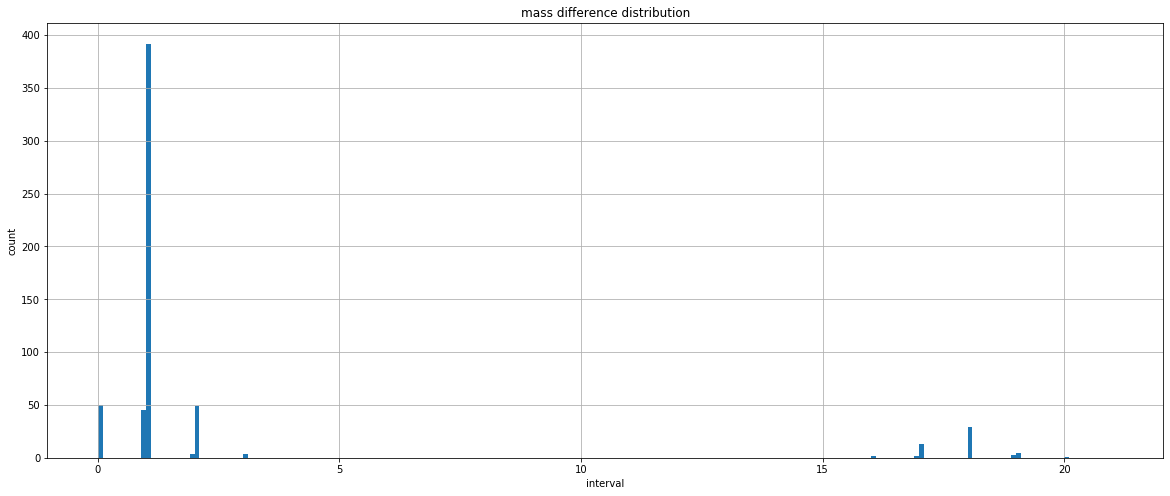

In [173]:
#mass difference plot
all_data_isotope=[]
for i in range(len(difference_isotope)):
    for j in range(len(difference_isotope[i])):
        all_data_isotope.append(difference_isotope[i][j])
final_data_isotope=np.array(all_data_isotope)
#final_data
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution")
plt.grid(True)
plt.hist(final_data_isotope, bins=np.arange(0, max(final_data_isotope)+1, 0.1))

319425.53125
80265.1953125 155238912.0


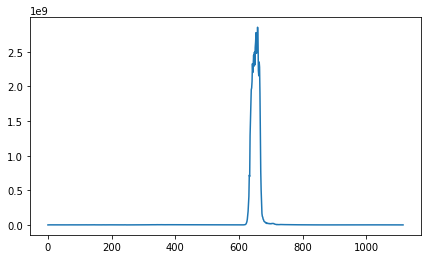

In [66]:
intensity_0=cluster[1][0].get_intensity_list()
rt_0=cluster[1][0].get_rt_list()
#print(min(intensity_0),max(intensity_0))
#print(min(rt_0),max(rt_0))
#print(intensity_0[0])
print(intensity_0[len(intensity_0)-1])
intensity_1=cluster[1][1].get_intensity_list()
rt_1=cluster[1][1].get_rt_list()
print(min(intensity_1),max(intensity_1))
#print(min(rt_1),max(rt_1))
plt.figure(figsize=(7,4))
plt.plot(rt_0,intensity_0)

In [23]:
cluster[0][0].get_mean_mz()

116.07058797746697

In [24]:
#mass difference list
difference=[]
for group_num in range(len(cluster)):
    diff_list=[]
    for i in range(len(cluster[group_num])):
        for j in range(i+1,len(cluster[group_num])):
            diff_list.append(abs(cluster[group_num][i].get_mean_mz()-cluster[group_num][j].get_mean_mz()))
    difference.append(diff_list)
print(difference)

[[1.0033224025173269, 46.005429494627606, 0.9970387125754598, 2.0041782431180195, 41.02661853980277, 2.0065551921177587, 45.0020687867289, 115.06334519581861, 47.00875189714493, 0.00628368994186701, 1.0008558406006927, 40.02329613728544, 1.0032327896004318, 46.005391189246225, 114.06002279330129, 47.002468207203066, 48.009607737745625, 87.03204803443037, 48.011984686745365, 1.0033607078987075, 161.06877469044622, 1.0071395305425597, 40.02957982722731, 1.0095164795422988, 45.99910749930436, 114.06630648324315, 39.02244029668475, 0.00237694899973917, 47.00624702984692, 113.0591669527006, 39.02006334768501, 86.02868732653167, 74.03672665601584, 47.00862397884666, 113.05679000370085, 160.0654139825475], [1.003455509983155, 2.0043297632443995, 0.9972247624305908, 139.0609931068859, 2.00674718135474, 21.98196541079659, 1.0008742532612445, 0.006230747552564253, 138.05753759690273, 1.003291671371585, 20.978509900813435, 1.0071050008138087, 137.0566633436415, 0.0024174181103404635, 19.977635647

array([1.00332240e+00, 4.60054295e+01, 9.97038713e-01, 2.00417824e+00,
       4.10266185e+01, 2.00655519e+00, 4.50020688e+01, 1.15063345e+02,
       4.70087519e+01, 6.28368994e-03, 1.00085584e+00, 4.00232961e+01,
       1.00323279e+00, 4.60053912e+01, 1.14060023e+02, 4.70024682e+01,
       4.80096077e+01, 8.70320480e+01, 4.80119847e+01, 1.00336071e+00,
       1.61068775e+02, 1.00713953e+00, 4.00295798e+01, 1.00951648e+00,
       4.59991075e+01, 1.14066306e+02, 3.90224403e+01, 2.37694900e-03,
       4.70062470e+01, 1.13059167e+02, 3.90200633e+01, 8.60286873e+01,
       7.40367267e+01, 4.70086240e+01, 1.13056790e+02, 1.60065414e+02])

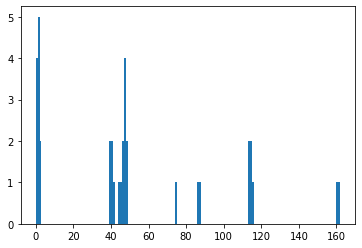

In [25]:
#mass difference sample plot
data=np.array(difference[0])
plt.hist(data, bins=np.arange(min(data), max(data) + 1, 1))
data
#plt.hist(data, bins=range(min(data), max(data) + 1, 1))

(array([ 69.,  64., 396., ...,   0.,   1.,   0.]),
 array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.340e+02, 9.345e+02,
        9.350e+02]),
 <a list of 1870 Patch objects>)

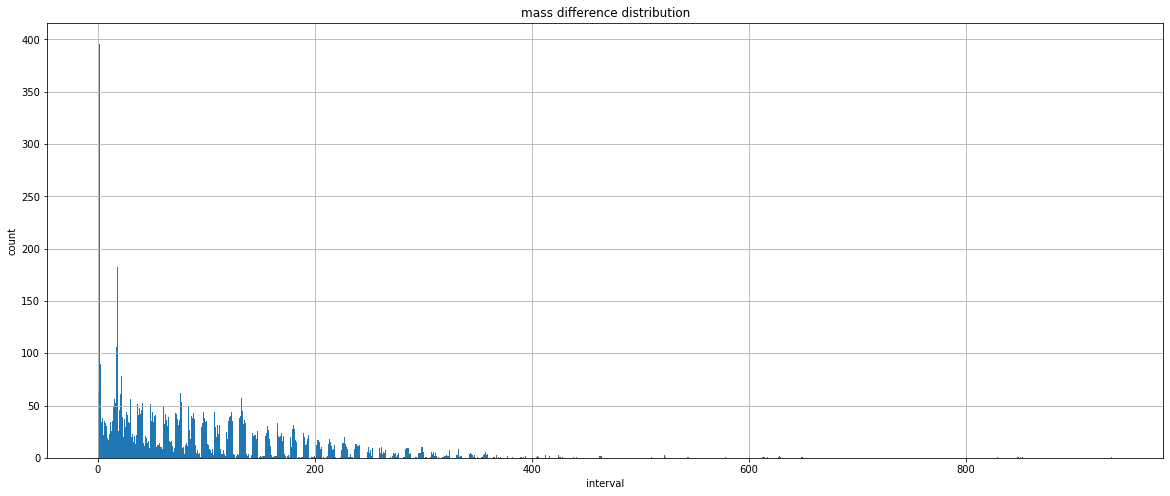

In [26]:
#mass difference plot
all_data=[]
for i in range(len(difference)):
    for j in range(len(difference[i])):
        all_data.append(difference[i][j])
final_data=np.array(all_data)
#final_data
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution")
plt.grid(True)
plt.hist(final_data, bins=np.arange(0, max(final_data)+1, 0.5))

(array([ 69.,  64., 396.,  31.,  90.,  25.,  34.,  41.,  38.,  47.,  22.,
         23.,  35.,  33.,  25.,  30.,  33.,  19.,  30.,  17.,  24.,  23.,
         21.,  34.,  24.,  26.,  35.,  19.,  49.,  36.,  56.,  55.,  52.,
         31., 106.,  17., 182.,  26., 101.,  46.,  45.,  61.,  31.,  78.,
         30.,  39.,  45.,  20.,  37.,  26.,  29.,  15.,  44.,  21.,  41.,
         28.,  34.,  17.,  33.,  18.,  56.,  20.,  42.,  23.,  47.,  15.,
         36.,  21.,  46.,  13.,  54.,  22.,  51.,  23.,  41.,  28.,  48.,
         29.,  42.,  60.,  46.,  23.,  52.,  14.,  41.,  11.,  40.,  21.,
         44.,  19.,  44.,  14.,  55.,  16.,  57.,   9.,  51.,  20.,  35.,
         12.,  44.,  19.,  34.,  17.,  40.,   5.,  41.,  10.,  38.,  12.,
         34.,  12.,  52.,  14.,  45.,  10.,  64.,  10.,  50.,   8.,  50.,
          8.,  32.,  14.,  42.,  12.,  36.,   9.,  30.,  13.,  39.,  16.,
         36.,  15.,  24.,  16.,  37.,  11.,  38.,   6.,  42.,   9.,  43.,
         11.,  42.,  10.,  37.,   5., 

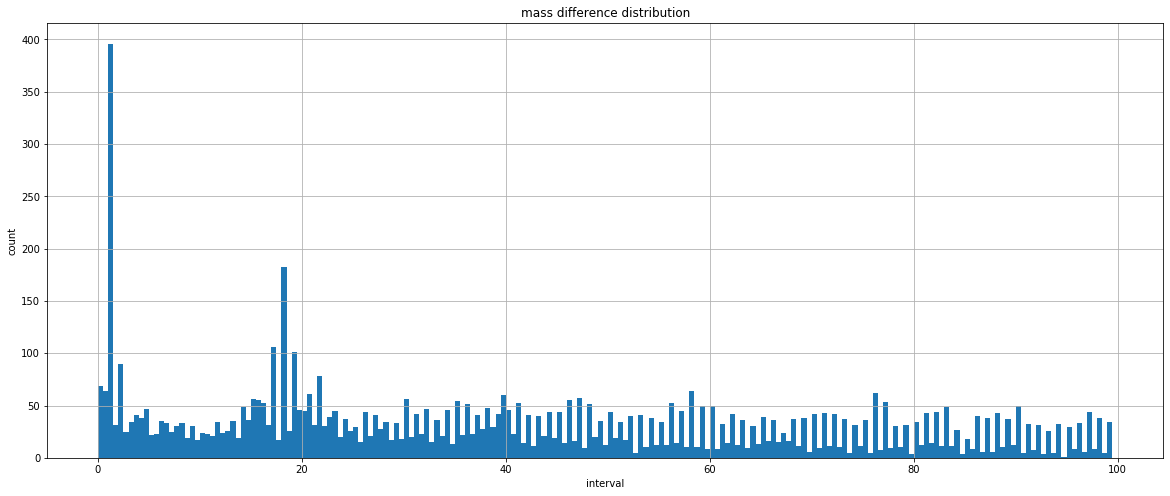

In [27]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution")
plt.grid(True)
plt.hist(final_data, bins=np.arange(0, 100, 0.5))

In [28]:
#between 18-18.5
#[M+H2O+H]+	1	H3O	NA	19.0178364520907	1
#[M+H+K]2+	2	HK	NA	19.9852172760907	0.5
#[M+NH4]+	1	NH4	NA	18.0338255480907	1
#[2M+NH4]+	1	NH4	NA	18.0338255480907	2
#mixture possible?

(array([ 69.,   0.,  10.,   0.,  54., 394.,   2.,   0.,   0.,  31.,  90.,
          0.,   0.,   0.,  25.,  34.,   0.,   0.,   0.,  41.,  38.,   0.,
          0.,   0.,  47.,  21.,   0.,   1.,   0.,  23.,  35.,   0.,   2.,
          0.,  31.,  22.,   0.,   5.,   0.,  28.,  31.,   1.,   2.,   0.,
         18.,  30.,   0.,   0.,   0.,  17.,  23.,   1.,   1.,   0.,  22.,
         21.,   0.,   1.,   0.,  33.,  24.,   0.,   0.,   0.,  26.,  35.,
          0.,   0.,   1.,  18.,  49.,   0.,   6.,   0.,  30.,  55.,   0.,
          6.,   0.,  50.,  52.,   0.,   0.,   0.,  31., 106.,   0.,   0.,
          0.,  17., 182.,   0.,   0.,   0.,  26., 100.,   0.,   1.,   0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6

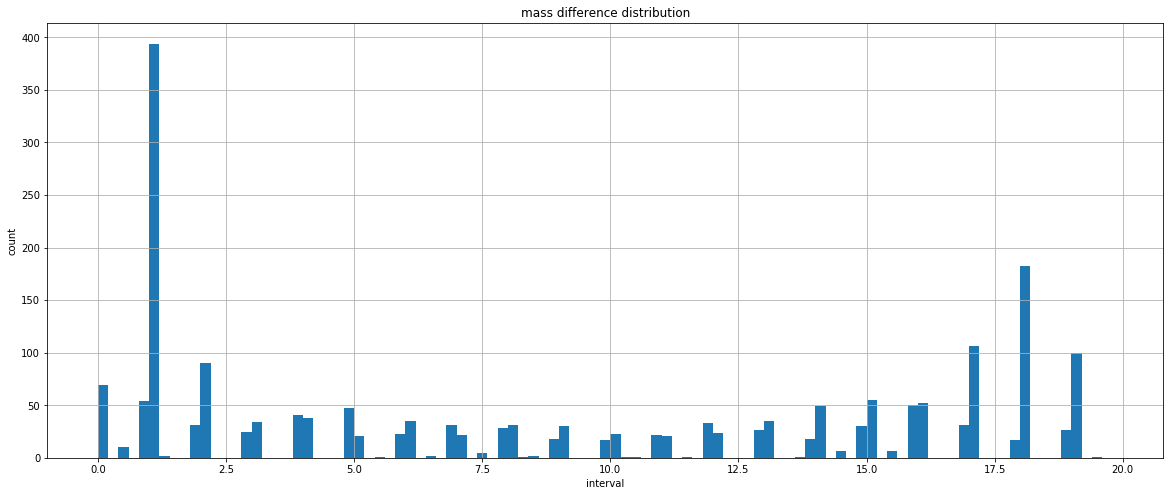

In [29]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution")
plt.grid(True)
plt.hist(final_data, bins=np.arange(0, 20, 0.2))

In [30]:
len(final_data)

10696

In [31]:
#mass difference baseline list
baseline_diff=[]
for i in range(len(good_roi)):
    for j in range(i+1,len(good_roi)):
        baseline_diff.append(abs(good_roi[i].get_mean_mz()-good_roi[j].get_mean_mz()))
print(len(baseline_diff))

21454525


In [32]:
import random
random_baseline=random.choices(baseline_diff,k=10696)
#print(random_baseline)

(array([40., 33., 27., ...,  0.,  1.,  0.]),
 array([3.16389588e-06, 5.00003164e-01, 1.00000316e+00, ...,
        9.40000003e+02, 9.40500003e+02, 9.41000003e+02]),
 <a list of 1882 Patch objects>)

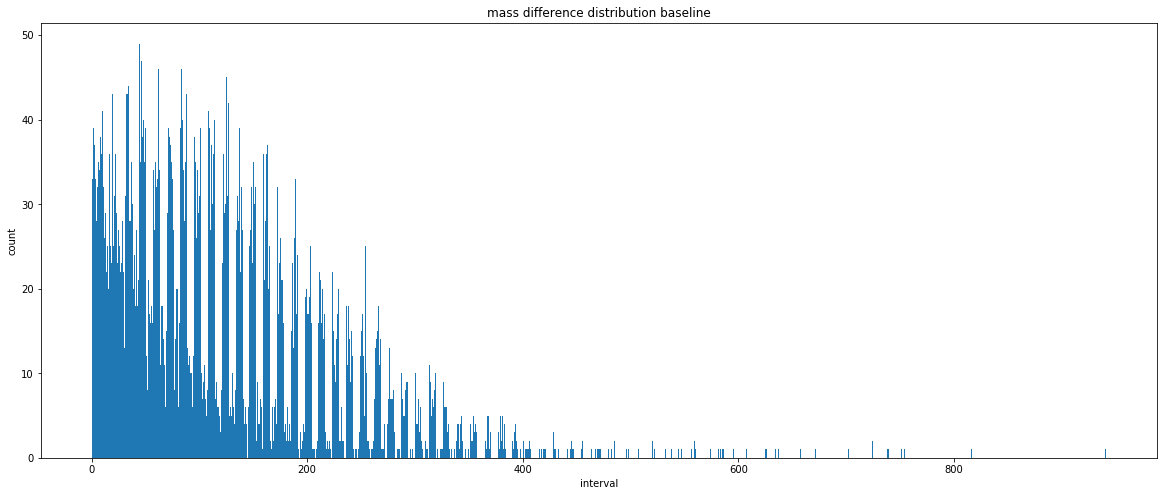

In [33]:
#mass difference baseline plot
baseline_data=np.array(random_baseline)
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline")
plt.hist(baseline_data, bins=np.arange(min(baseline_data), max(baseline_data) + 1, 0.5))

(array([40., 33., 27., 39., 39., 37., 31., 33., 30., 28., 29., 32., 35.,
        32., 34., 22., 38., 27., 36., 18., 41., 19., 32., 28., 26., 29.,
        33., 22., 36., 25., 20., 20., 35., 36., 21., 25., 34., 23., 43.,
        32., 25., 22., 31., 21., 36., 25., 29., 26., 23., 27., 39., 25.,
        41., 22., 36., 23., 42., 28., 26., 22., 34., 13., 31., 31., 43.,
        17., 43., 20., 44., 24., 28., 21., 28., 26., 35., 30., 38., 20.,
        37., 24., 31., 18., 43., 27., 31., 18., 35., 21., 49., 16., 35.,
        15., 47., 18., 38., 16., 40., 20., 35., 27., 39., 12., 36.,  8.,
        26., 21., 38., 17., 29., 16., 42., 18., 37., 16., 34., 17., 27.,
        17., 35., 12., 32., 20., 33., 15., 46., 17., 34., 11., 35., 18.,
        38., 18., 31., 14., 31., 11., 35.,  6., 32., 15., 29.,  9., 39.,
        17., 38., 14., 37., 11., 35., 15., 33., 11., 27.,  8., 40., 14.,
        36., 20., 35., 20., 36.,  6., 28., 16., 39., 13., 46., 11., 40.,
        11., 34., 11., 28., 14., 35., 12., 43., 13.

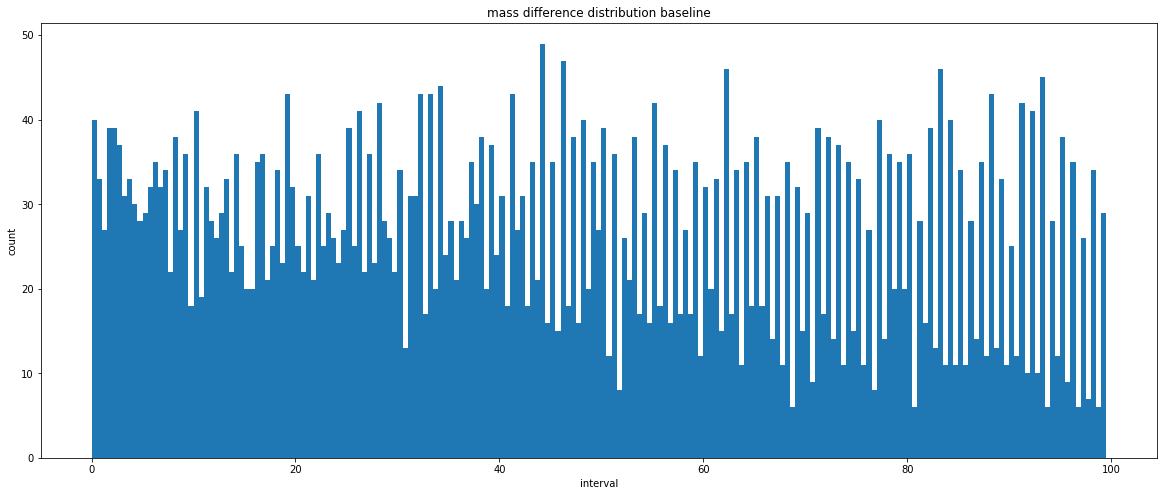

In [34]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline")
plt.hist(baseline_data, bins=np.arange(min(baseline_data), 100, 0.5))

In [ ]:
#plot the difference with highest intensity
#calculate mean intensity

#from numpy import *
#mass_diff_list=[]
#for group_num in range(len(cluster)):
#    mean_intensity_list=[]
#    temp_list=[]
#    for i in range(len(cluster[group_num])):
#        mean_intensity_list.append(mean(cluster[group_num][i].get_intensity_list()))
#        temp_list.append(cluster[group_num][i].get_mean_mz())
#    max_index=mean_intensity_list.index(max(mean_intensity_list))
#    max_intensity_mean_mz=cluster[7][max_index].get_mean_mz()
#    del temp_list[max_index]
#    add_mass_diff_list=[]
#    for j in range(len(temp_list)):
#        add_mass_diff_list.append(abs(temp_list[j]-max_intensity_mean_mz))
#    mass_diff_list.append(add_mass_diff_list)
#print(mass_diff_list)


In [35]:
high_all_data=[]
for i in range(len(cluster)):
    for j in range(len(cluster[i])-1):
        high_all_data.append(abs(cluster[i][0].get_mean_mz()-cluster[i][j+1].get_mean_mz()))
print(high_all_data)
        

[1.0033224025173269, 46.005429494627606, 0.9970387125754598, 2.0041782431180195, 41.02661853980277, 2.0065551921177587, 45.0020687867289, 115.06334519581861, 1.003455509983155, 2.0043297632443995, 0.9972247624305908, 139.0609931068859, 2.00674718135474, 21.98196541079659, 1.0033826645186679, 0.997088390842876, 1.0062493611892478, 2.004258198536732, 27.010983280168688, 2.006533264423396, 21.981841346453848, 1.003252253210178, 279.0852054331095, 2.0041497142935327, 22.98523498660154, 74.03655438789073, 257.1032055726185, 133.1103736306693, 23.986412110336857, 3.0076047920761084, 37.09134321621954, 152.99954539966086, 159.12597017996353, 1.0033064741429314, 117.07882908766834, 2.0041431644098395, 0.9971740758100509, 1.00333497018525, 2.0042209972034755, 0.9973590023867587, 2.0066959727894016, 106.02437730268997, 109.07385035556572, 21.982038423612522, 61.008609424937845, 44.997931046919405, 167.0794278124829, 120.08988467129791, 1.0033616426732124, 136.02690197766375, 0.9970719698216612, 

(array([ 35., 173.,  56.,  13.,  16.,  10.,   7.,  10.,   8.,   8.,   7.,
          8.,   9.,   8.,  22.,  20.,  15.,  37.,  53.,   8.,  12.,  36.,
          8.,  11.,   5.,   4.,   6.,   9.,  11.,  10.,  10.,  11.,  10.,
          8.,  10.,  17.,  11.,   9.,   2.,  18.,  10.,  12.,   8.,   9.,
         10.,  11.,  22.,   5.,   6.,  12.,   6.,   3.,   8.,   2.,   7.,
          7.,  10.,  14.,   6.,  11.,   8.,   6.,   6.,   9.,   4.,  10.,
          8.,   4.,   8.,   8.,   4.,   6.,   6.,   7.,   8.,   6.,   3.,
          8.,   8.,   5.,  14.,   7.,  11.,   6.,   5.,   3.,   3.,   4.,
         13.,   9.,   3.,   6.,   6.,   5.,   4.,   3.,   6.,   8.,   5.,
          5.,   5.,   7.,   6.,   4.,   3.,   3.,  10.,   3.,   1.,   3.,
          4.,   2.,   5.,   7.,   3.,   8.,   7.,   5.,   2.,   5.,   8.,
          7.,   6.,   5.,   4.,   2.,   2.,   4.,   5.,   4.,   4.,  13.,
         12.,   8.,   6.,   6.,   6.,   4.,   7.,   4.,   6.,   3.,   4.,
          5.,   3.,   4.,   2.,   7., 

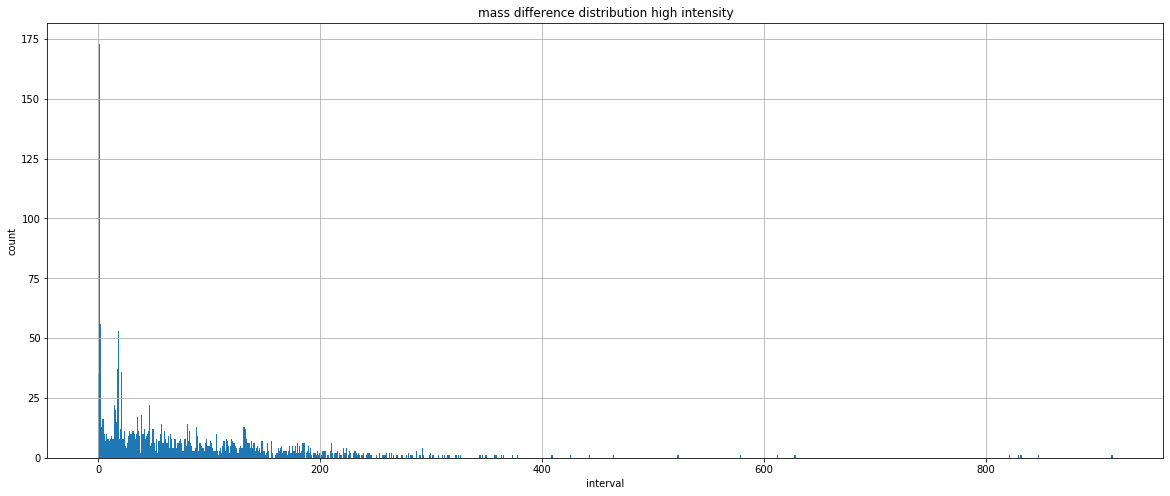

In [36]:
high_final_data=np.array(high_all_data)
#high_final_data
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution high intensity")
plt.grid(True)
plt.hist(high_final_data, bins=np.arange(0, max(high_final_data)+1, 1))

(array([  4.,  31., 165.,   8.,  50.,   6.,   8.,   5.,   3.,  13.,   5.,
          5.,   5.,   2.,   3.,   7.,   6.,   2.,   5.,   3.,   4.,   3.,
          2.,   6.,   4.,   5.,   6.,   2.,  16.,   6.,  10.,  10.,  12.,
          3.,  35.,   2.,  53.,   0.,   7.,   1.,   6.,   6.,   5.,  31.,
          3.,   5.,   5.,   6.,   5.,   0.,   2.,   2.,   5.,   1.,   5.,
          4.,   9.,   2.,   6.,   4.,   6.,   4.,   7.,   4.,   8.,   2.,
          4.,   4.,   8.,   2.,  13.,   4.,   8.,   3.,   5.,   4.,   2.,
          0.,  11.,   7.,   5.,   5.,  12.,   0.,   7.,   1.,   8.,   1.,
          6.,   4.,  10.,   1.,  20.,   2.,   4.,   1.,   6.,   0.,   7.,
          5.,   4.,   2.,   2.,   1.,   8.,   0.,   2.,   0.,   5.,   2.,
          7.,   0.,   9.,   1.,  11.,   3.,   4.,   2.,   9.,   2.,   7.,
          1.,   5.,   1.,   5.,   1.,   8.,   1.,   3.,   1.,   9.,   1.,
          6.,   2.,   1.,   3.,   6.,   2.,   7.,   1.,   4.,   0.,   6.,
          0.,   4.,   2.,   7.,   0., 

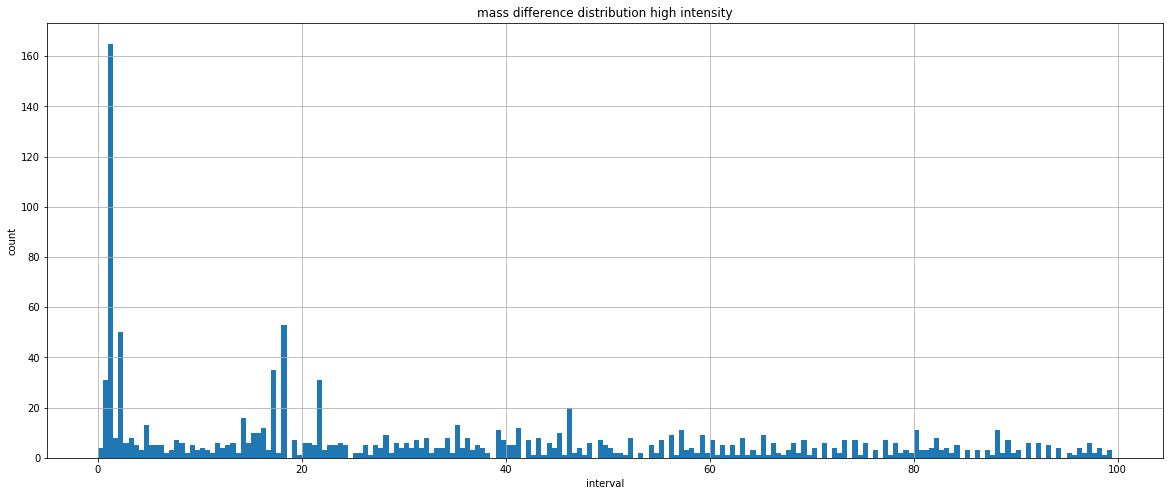

In [40]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution high intensity")
plt.grid(True)
plt.hist(high_final_data, bins=np.arange(0, 100, 0.5))

In [38]:
len(high_final_data)

1719

In [39]:
random_baseline_high_intensity=random.choices(baseline_diff,k=1719)
#print(random_baseline)

(array([2., 6., 0., ..., 0., 0., 0.]),
 array([3.16389588e-06, 5.00003164e-01, 1.00000316e+00, ...,
        9.40000003e+02, 9.40500003e+02, 9.41000003e+02]),
 <a list of 1882 Patch objects>)

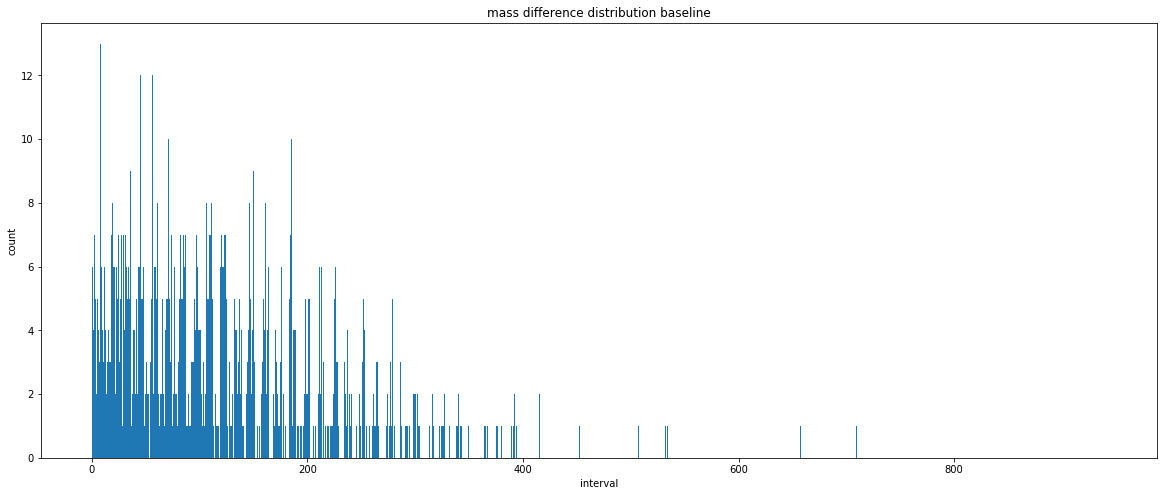

In [41]:
baseline_data_high_intensity=np.array(random_baseline_high_intensity)
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline")
plt.hist(baseline_data_high_intensity, bins=np.arange(min(baseline_data), max(baseline_data) + 1, 0.5))

(array([ 2.,  6.,  0.,  4.,  7.,  7.,  2.,  5.,  2.,  2.,  5.,  5.,  4.,
         2.,  3.,  5., 13.,  5.,  6.,  5.,  4.,  3.,  5.,  6.,  5.,  4.,
         9.,  2.,  3.,  3.,  3.,  4.,  4.,  3.,  3.,  5.,  7.,  4.,  8.,
         2.,  6.,  6.,  6.,  4.,  2.,  8.,  6.,  5.,  9.,  7.,  4.,  3.,
         6.,  5.,  4.,  7.,  7.,  1.,  4.,  7.,  4.,  5.,  7.,  4.,  6.,
         5.,  5.,  4.,  6.,  3.,  5.,  0.,  9.,  1.,  2.,  2.,  6.,  4.,
         5.,  4.,  3.,  2.,  9.,  5.,  6.,  2.,  6.,  6.,  6.,  2., 12.,
         3.,  5.,  5.,  5.,  3.,  6.,  1.,  8.,  2.,  1.,  3.,  4.,  2.,
         4.,  2.,  6.,  0.,  6.,  3.,  5.,  2., 12.,  5.,  2.,  4.,  6.,
         7.,  6.,  2.,  5.,  1.,  8.,  2.,  8.,  1.,  6.,  2.,  7.,  2.,
         8.,  5.,  4.,  2.,  8.,  1.,  4.,  4.,  5.,  4.,  5.,  1., 10.,
         3.,  5.,  3.,  3.,  1.,  7.,  1.,  3.,  2.,  4.,  6.,  7.,  2.,
         4.,  2.,  6.,  1.,  9.,  3.,  5.,  1.,  7.,  3.,  5.,  5.,  5.,
         1.,  7.,  0.,  6.,  1.,  7.,  1.,  1.,  1.

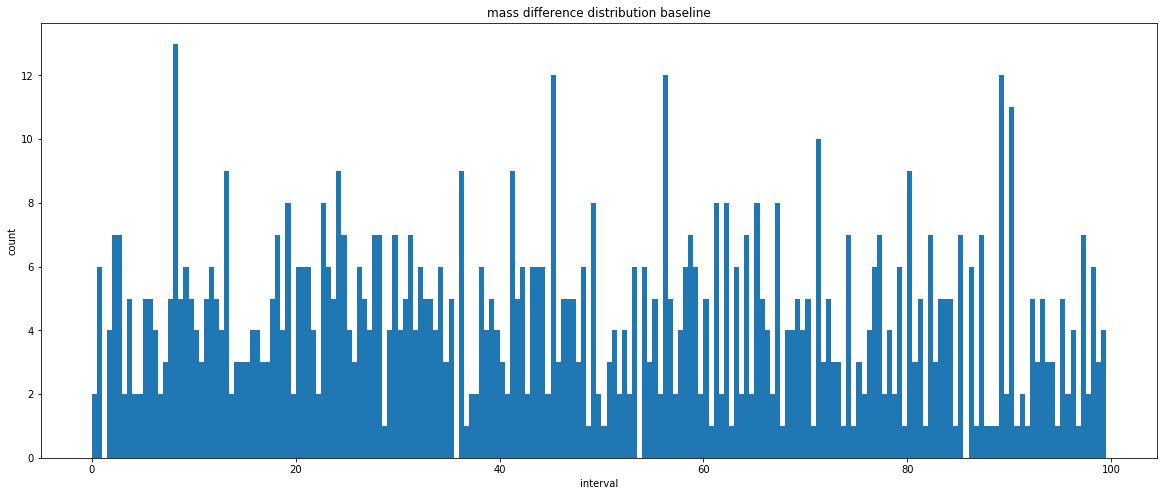

In [42]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline")
plt.hist(baseline_data_high_intensity, bins=np.arange(min(baseline_data), 100, 0.5))

In [ ]:
#file2

In [43]:
input_file2 = '/Users/tong/Downloads/Beer_multibeers_2_fullscan1.mzML'
good_roi2=make_roi(input_file2)

In [44]:
def greedy_roi_cluster(roi_list, corr_thresh=0.9, corr_type='cosine'):
    # sort in descending intensity
    roi_list_copy = [r for r in roi_list]
    roi_list_copy.sort(key=lambda x: max(x.intensity_list), reverse=True)
    roi_clusters = []
    while len(roi_list_copy) > 0:
        roi_clusters.append([roi_list_copy[0]])
        remove_idx = [0]
        if len(roi_list_copy) > 1:
            for i, r in enumerate(roi_list_copy[1:]):
                corr = roi_correlation(roi_list_copy[0], r)
                if corr > corr_thresh:
                    roi_clusters[-1].append(r)
                    remove_idx.append(i + 1)
        remove_idx.sort(reverse=True)
        for r in remove_idx:
            del roi_list_copy[r]

    return roi_clusters

In [45]:
cluster2=greedy_roi_cluster(good_roi2)

In [46]:
print(cluster2)

[[ROI with data points=865 mz (118.0862-118.0861) rt (0.1230-1113.7700) mean_mz (118.0862) 
, ROI with data points=86 mz (119.0896-119.0896) rt (610.6040-716.4300) mean_mz (119.0895) 
, ROI with data points=41 mz (120.0904-120.0904) rt (620.5680-670.3520) mean_mz (120.0904) 
, ROI with data points=42 mz (119.0833-119.0834) rt (619.3270-670.3520) mean_mz (119.0833) 
, ROI with data points=32 mz (257.1474-257.1472) rt (626.8410-665.3540) mean_mz (257.1469) 
, ROI with data points=39 mz (120.0928-120.0926) rt (620.5680-667.8750) mean_mz (120.0928) 
, ROI with data points=47 mz (140.0679-140.0678) rt (616.8420-674.0650) mean_mz (140.0680) 
], [ROI with data points=593 mz (116.0709-116.0706) rt (655.4090-1441.3800) mean_mz (116.0706) 
, ROI with data points=334 mz (117.0739-117.0739) rt (687.7650-1117.6300) mean_mz (117.0739) 
, ROI with data points=358 mz (70.0650-70.0652) rt (664.1140-1113.7700) mean_mz (70.0651) 
, ROI with data points=44 mz (118.0748-118.0747) rt (702.7740-756.4500) mea

In [47]:
#mass difference list2
difference2=[]
for group_num in range(len(cluster2)):
    diff_list2=[]
    for i in range(len(cluster2[group_num])):
        for j in range(i+1,len(cluster2[group_num])):
            diff_list2.append(abs(cluster2[group_num][i].get_mean_mz()-cluster2[group_num][j].get_mean_mz()))
    difference2.append(diff_list2)
print(difference2)

[[1.0033328102871764, 2.0041658445320962, 0.9970887127179822, 139.06065174168936, 2.006595427367671, 21.981784174342877, 1.0008330342449199, 0.006244097569194196, 138.05731893140216, 1.0032626170804946, 20.9784513640557, 1.007077131814114, 137.05648589715724, 0.0024295828355747062, 19.97761832981078, 138.06356302897137, 1.0095067146496888, 20.984695461624895, 137.05405631432166, 117.07886756734646, 19.975188746975206], [1.0033185474489699, 46.00545767782204, 2.0041594016265094, 0.9970099306903393, 41.02654915800025, 190.01003898131094, 2.0065248029234226, 45.00207901087907, 115.063149860876, 2.000342692975053, 44.99781843220805, 47.008776225271006, 1.0008408541775395, 0.006308616758630592, 40.02323061055128, 189.00672043386197, 1.0032062554744527, 46.00539755832804, 114.05983131342703, 0.9970241455260833, 46.00113697965702, 48.009617079448546, 47.002467608512376, 87.03200683582229, 236.01549665913296, 48.01198248074546, 1.0033786669429645, 161.06860753869802, 48.00580037079709, 1.00763

(array([101., 125., 405.,  59.,  95.,  48.,  37.,  60.,  51.,  57.,  44.,
         40.,  44.,  39.,  32.,  37.,  39.,  37.,  32.,  35.,  41.,  46.,
         32.,  63.,  37.,  41.,  55.,  41.,  77.,  46.,  58.,  67.,  77.,
         41., 141.,  34., 206.,  33., 130.,  39.,  56.,  60.,  45.,  89.,
         60.,  45.,  67.,  38.,  62.,  26.,  45.,  35.,  67.,  30.,  56.,
         42.,  50.,  45.,  46.,  27.,  68.,  37.,  59.,  34.,  48.,  27.,
         43.,  24.,  59.,  20.,  65.,  31.,  61.,  27.,  56.,  36.,  48.,
         36.,  58.,  51.,  78.,  34.,  74.,  25.,  84.,  15.,  62.,  21.,
         65.,  20.,  57.,  33.,  91.,  20.,  90.,  21.,  67.,  10.,  47.,
         24.,  43.,  21.,  48.,  15.,  53.,  16.,  51.,  21.,  52.,  18.,
         37.,  19.,  51.,  21.,  63.,  17.,  69.,  16.,  66.,  16.,  68.,
         16.,  48.,  27.,  39.,  12.,  55.,  12.,  39.,   9.,  43.,  14.,
         60.,  15.,  44.,  24.,  48.,  12.,  49.,  12.,  59.,  19.,  62.,
         12.,  76.,   7.,  56.,  18., 

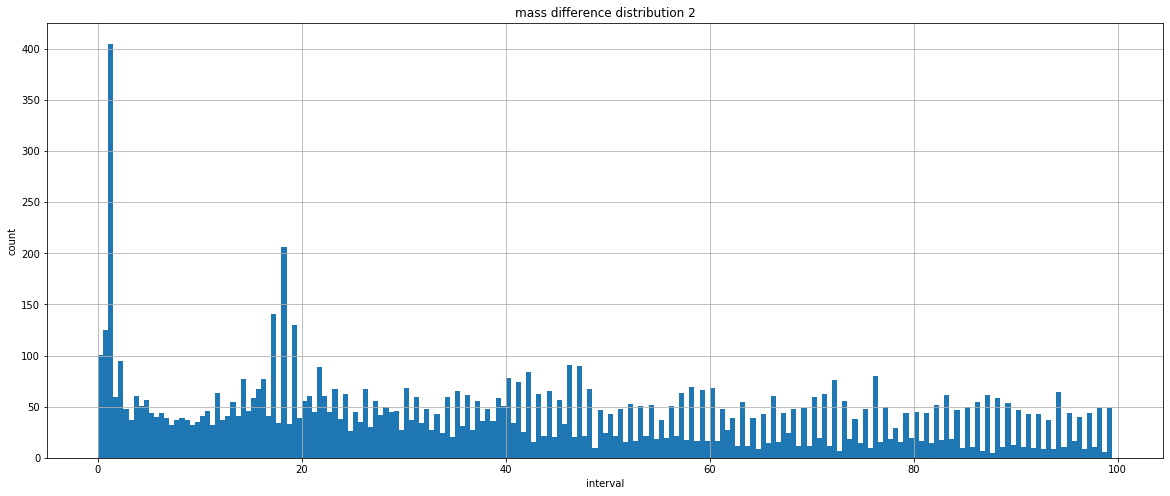

In [48]:
#mass difference plot2
all_data2=[]
for i in range(len(difference2)):
    for j in range(len(difference2[i])):
        all_data2.append(difference2[i][j])
final_data2=np.array(all_data2)
#final_data
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution 2")
plt.grid(True)
plt.hist(final_data2, bins=np.arange(min(final_data2), 100, 0.5))

In [ ]:
#17.9-18.1
#[M+NH4]+	1	NH4	NA	18.0338255480907	1
#[2M+NH4]+	1	NH4	NA	18.0338255480907	2

In [49]:
#mass difference baseline list2
baseline_diff2=[]
for i in range(len(good_roi2)):
    for j in range(i+1,len(good_roi2)):
        baseline_diff2.append(abs(good_roi2[i].get_mean_mz()-good_roi2[j].get_mean_mz()))
print(len(baseline_diff2))

22798128


In [50]:
len(final_data2)

14623

In [51]:
import random
random_baseline2=random.choices(baseline_diff2,k=14623)
print(random_baseline2)

[159.00331821441648, 123.129951245857, 41.01521247863769, 40.86086288452148, 314.1635346924751, 9.984362554366072, 121.01612161489635, 65.98508225028397, 52.978743535822105, 120.94330749511721, 229.11595810599948, 23.988780690526312, 238.10072487631996, 96.0535329681596, 191.62995712478437, 87.0783971150716, 235.1094012187964, 33.56229364871979, 44.00108387992981, 59.07324463980538, 119.98651502454604, 25.006481372678763, 55.12853029611949, 289.1391804435036, 80.00686790829613, 133.58371440153897, 92.06784261067713, 33.01513449928973, 62.95892107928242, 43.04205915662976, 210.1030916849772, 28.95884087745185, 19.00733663521561, 110.01563188246081, 129.08517573429987, 29.989495008419738, 228.10177001953127, 49.22153875896157, 26.095587391299944, 135.021037756228, 181.24456599308894, 18.994505201067227, 155.06879773821152, 198.09326662336076, 65.04754887794957, 49.020454445512485, 164.12392737648702, 104.02631711269947, 221.0547084263393, 97.08177924138002, 15.040079948984982, 15.9601836

(array([46., 50., 45., ...,  0.,  1.,  0.]),
 array([3.59671456e-06, 5.00003597e-01, 1.00000360e+00, ...,
        9.11000004e+02, 9.11500004e+02, 9.12000004e+02]),
 <a list of 1824 Patch objects>)

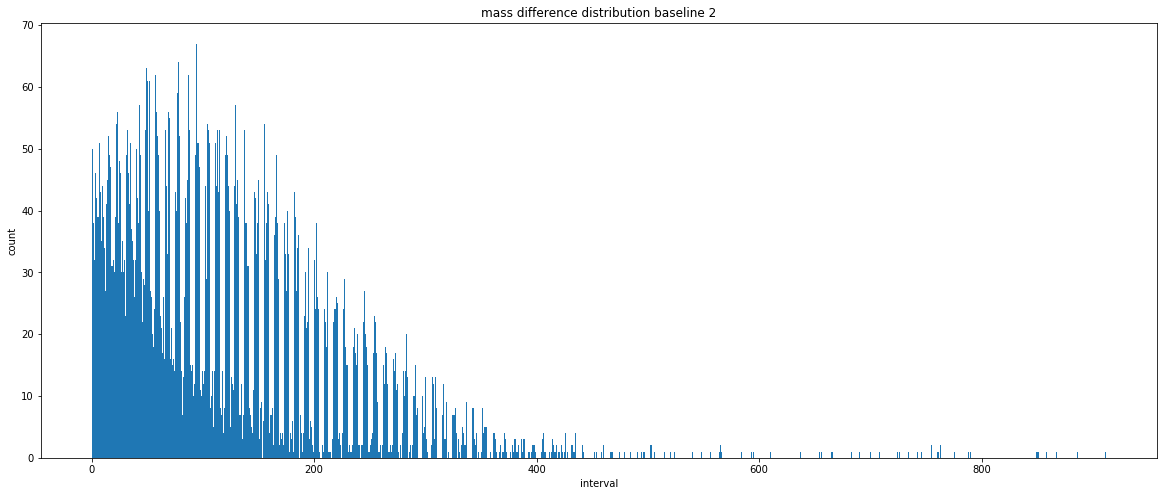

In [52]:
#mass difference baseline plot 2
baseline_data2=np.array(random_baseline2)
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline 2")
plt.hist(baseline_data2, bins=np.arange(min(baseline_data2), max(baseline_data2) + 1, 0.5))

(array([46., 50., 45., 38., 43., 32., 39., 46., 42., 44., 39., 39., 39.,
        34., 51., 34., 43., 35., 42., 44., 42., 39., 46., 34., 58., 27.,
        41., 31., 45., 37., 52., 46., 49., 34., 47., 31., 42., 31., 59.,
        32., 38., 30., 54., 39., 54., 31., 56., 40., 38., 29., 48., 31.,
        46., 30., 53., 35., 59., 30., 41., 32., 50., 23., 49., 30., 53.,
        37., 46., 36., 41., 31., 51., 37., 48., 35., 50., 32., 51., 26.,
        44., 32., 50., 30., 42., 37., 38., 23., 57., 24., 49., 30., 51.,
        22., 34., 29., 54., 28., 53., 26., 63., 28., 61., 16., 40., 33.,
        61., 27., 43., 26., 42., 20., 56., 18., 46., 24., 62., 23., 56.,
        22., 52., 19., 49., 24., 40., 23., 56., 21., 42., 17., 35., 26.,
        54., 16., 53., 20., 44., 18., 33., 12., 56., 16., 55., 16., 50.,
        21., 50., 15., 44., 16., 42., 14., 43., 17., 40., 14., 59., 13.,
        64., 23., 52., 22., 59., 14., 45.,  7., 55., 13., 44., 26., 42.,
        17., 38., 14., 45.,  9., 62.,  9., 53., 15.

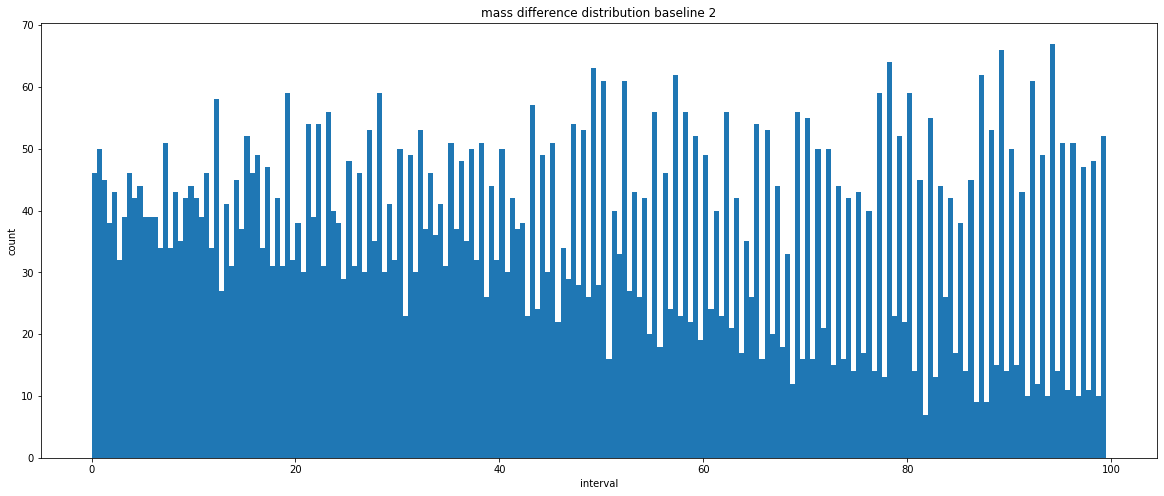

In [53]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline 2")
plt.hist(baseline_data2, bins=np.arange(min(baseline_data2), 100, 0.5))

In [54]:
high_all_data2=[]
for i in range(len(cluster2)):
    for j in range(len(cluster2[i])-1):
        high_all_data2.append(abs(cluster2[i][0].get_mean_mz()-cluster2[i][j+1].get_mean_mz()))
print(high_all_data2)
        

[1.0033328102871764, 2.0041658445320962, 0.9970887127179822, 139.06065174168936, 2.006595427367671, 21.981784174342877, 1.0033185474489699, 46.00545767782204, 2.0041594016265094, 0.9970099306903393, 41.02654915800025, 190.01003898131094, 2.0065248029234226, 45.00207901087907, 115.063149860876, 2.000342692975053, 44.99781843220805, 1.0033849317222234, 27.011006067949396, 0.9971014110125225, 2.00424714787178, 1.0062458317931657, 9.984405630702526, 2.006519297319514, 1.003266902104997, 279.0849777710743, 2.0040940418502373, 257.102860054603, 280.0882480586816, 133.1105142740103, 130.12167871915375, 3.0074946574675323, 152.99957702832347, 46.005560644000454, 1.0032775057636627, 45.0022040080072, 17.026591655528023, 23.999872361058294, 35.037138418689295, 63.03212023725524, 64.07160739418478, 204.0741969364368, 41.026472784059735, 0.9971304544765189, 2.0069823279651757, 59.03723090509082, 48.02123212378699, 2.0038074393837917, 354.1534997967025, 45.008358099134654, 75.03234087934509, 22.005

(array([  4.,  36., 181., ...,   0.,   0.,   0.]),
 array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.130e+02, 9.135e+02,
        9.140e+02]),
 <a list of 1828 Patch objects>)

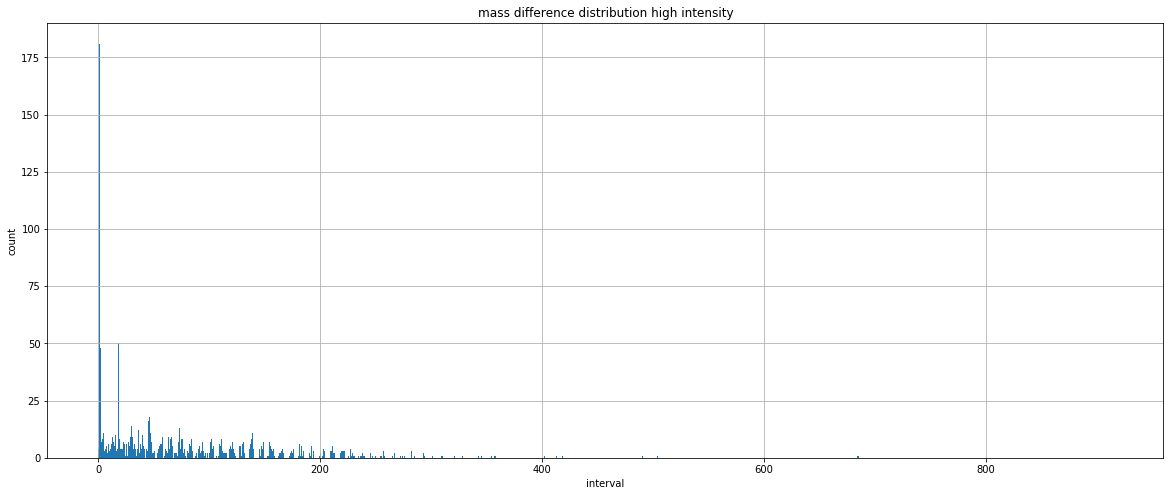

In [55]:
high_final_data2=np.array(high_all_data2)
#high_final_data
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution high intensity")
plt.grid(True)
plt.hist(high_final_data2, bins=np.arange(0, max(high_final_data)+1, 0.5))

(array([  4.,  36., 181.,   8.,  48.,   2.,   7.,   5.,   8.,  11.,   8.,
          3.,   3.,   4.,   3.,   5.,   5.,   2.,   6.,   7.,   3.,   4.,
          4.,   8.,   6.,   5.,   9.,   7.,  11.,   5.,   7.,  10.,  15.,
          3.,  42.,   4.,  50.,   2.,   8.,   3.,   4.,   5.,   4.,  22.,
          4.,   7.,  13.,   6.,   8.,   1.,   5.,   6.,   7.,   1.,   7.,
         10.,   5.,   1.,   9.,   5.,  14.,   3.,   9.,   4.,   5.,   6.,
          6.,   4.,  10.,   1.,  11.,   4.,  12.,   4.,   2.,   4.,   6.,
          3.,   4.,   7.,  10.,   5.,  12.,   4.,  11.,   0.,   8.,   4.,
         13.,   3.,  16.,   2.,  18.,   5.,  11.,   2.,   7.,   0.,   2.,
          2.,   5.,   3.,   7.,   0.,   6.,   0.,   3.,   2.,   4.,   3.,
          5.,   1.,   6.,   3.,   6.,   1.,   9.,   0.,   8.,   1.,   4.,
          4.,   3.,   3.,   4.,   2.,   9.,   2.,   4.,   0.,   8.,   0.,
          9.,   1.,   5.,   0.,   6.,   2.,   8.,   2.,   8.,   2.,   6.,
          1.,   7.,   1.,  13.,   2., 

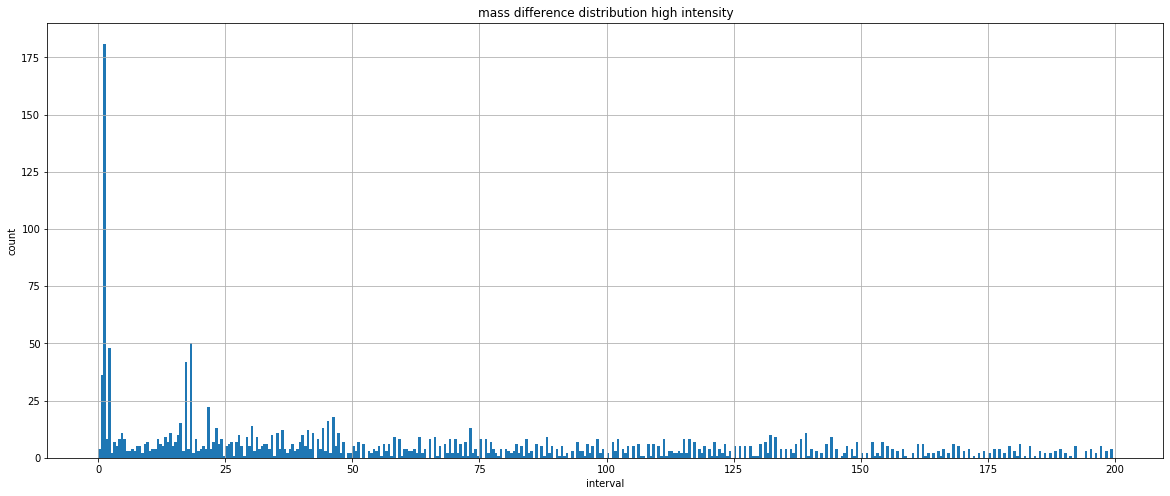

In [56]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution high intensity")
plt.grid(True)
plt.hist(high_final_data2, bins=np.arange(0, 200, 0.5))

In [57]:
len(high_final_data2)

1926

In [58]:
#baseline
random_baseline_high_intensity2=random.choices(baseline_diff2,k=1926)
print(random_baseline_high_intensity2)

[136.0522442441998, 101.92986821193324, 7.063138561088465, 101.58041136477476, 416.07403776466026, 176.06815537596057, 30.97943537370719, 121.0168520120474, 6.805787989820544, 76.9372799732646, 28.008760447316376, 114.09012563605057, 52.95840388706753, 127.95943736113836, 80.10940619134283, 105.98376295301654, 190.12721411861588, 107.03390220359518, 52.99014963968847, 188.09652965424826, 111.55704106585074, 72.06131992092381, 19.05927435906375, 200.17741745334203, 240.10338438400112, 111.12821103328723, 31.96177460831592, 21.9368813172793, 101.02247786088421, 30.844887162201474, 161.00671929166748, 110.09079066685268, 75.11467689691588, 30.928924560546875, 144.03198623657227, 11.996926959493862, 317.2483919238613, 68.93878189923893, 209.1708518134223, 126.02744441032411, 76.0160122495709, 102.01962876753373, 581.2161882967562, 110.09557415190199, 129.12527423434787, 124.0156898316014, 112.98770946174133, 118.00527801513672, 132.06569495567908, 26.530894886363626, 341.2734962145324, 49.

(array([4., 5., 8., ..., 0., 1., 0.]),
 array([1.99167352e-05, 5.00019917e-01, 1.00001992e+00, ...,
        8.78000020e+02, 8.78500020e+02, 8.79000020e+02]),
 <a list of 1758 Patch objects>)

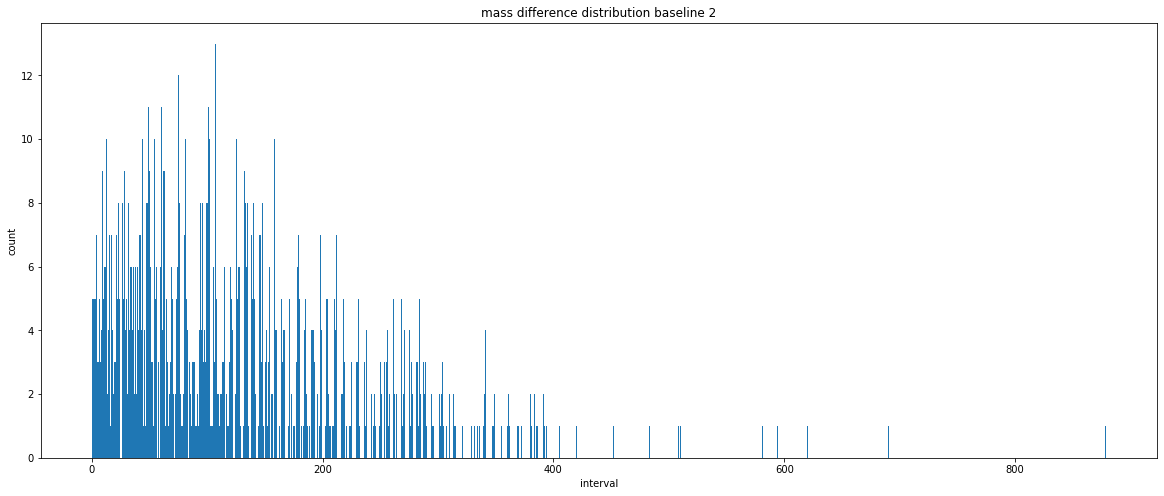

In [59]:
baseline_data_high_intensity_2=np.array(random_baseline_high_intensity2)
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline 2")
plt.hist(baseline_data_high_intensity_2, bins=np.arange(min(baseline_data_high_intensity_2), max(baseline_data_high_intensity_2) + 1, 0.5))

(array([ 4.,  5.,  8.,  5.,  5.,  2.,  5.,  6.,  7.,  3.,  3.,  3.,  4.,
         5.,  5.,  3.,  3.,  4.,  9.,  5.,  5.,  6.,  6.,  6.,  6., 10.,
         6.,  2.,  6.,  4.,  7.,  3.,  1.,  4.,  7.,  4.,  4.,  2.,  9.,
         3.,  5.,  3.,  6.,  7.,  5.,  5.,  8.,  5.,  5.,  0.,  7.,  0.,
         5.,  8.,  8.,  5.,  9.,  5.,  4.,  3.,  5.,  7.,  2.,  8.,  5.,
         4., 10.,  6.,  7.,  6.,  4.,  9.,  6.,  2.,  2.,  6.,  4.,  2.,
         6.,  6.,  1.,  4.,  7.,  3.,  7.,  3.,  4.,  3., 10.,  1.,  5.,
         4., 10.,  1.,  8.,  3.,  8.,  2., 11.,  6.,  9.,  6.,  6.,  3.,
        10.,  3.,  8.,  1., 10.,  4.,  5.,  6.,  6.,  0.,  0.,  3., 11.,
         0.,  2.,  6., 11.,  2.,  4.,  2.,  9.,  3.,  9.,  1., 13.,  5.,
         5.,  3.,  7.,  1.,  2.,  2.,  3.,  3.,  6.,  2.,  5.,  2.,  8.,
         0.,  6.,  2.,  5.,  2.,  6.,  1., 12.,  4.,  8.,  2., 12.,  1.,
         0.,  1., 10.,  2.,  7.,  0., 10.,  1.,  5.,  2.,  4.,  0.,  5.,
         3.,  4.,  2.,  1.,  2.,  3.,  3.,  3.,  5.

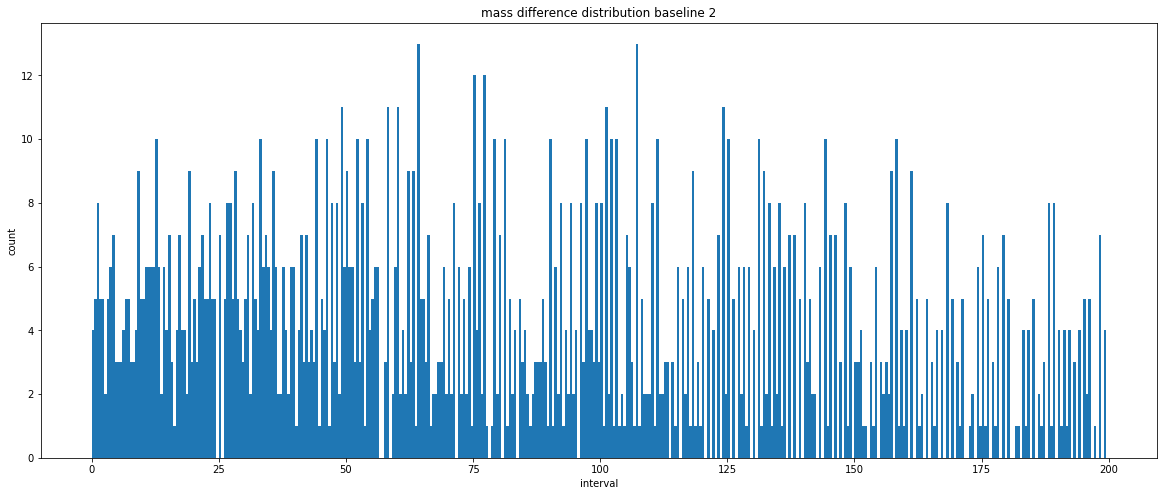

In [60]:
plt.figure(figsize=(20,8))
plt.xlabel('interval')
plt.ylabel("count")
plt.title("mass difference distribution baseline 2")
plt.hist(baseline_data_high_intensity_2, bins=np.arange(min(baseline_data_high_intensity_2), 200, 0.5))

In [ ]:
for i in range(len(cluster2[0])):
    intensity_0=np.array(cluster2[0][i].get_intensity_list())
    rt_0=np.array(cluster2[0][i].get_rt_list())
    #plt.figure(figsize=(7,4))
    plt.plot(rt_0,intensity_0)